In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

import prepare
import model

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize

# Acquire and Prep

In [2]:
# acquire dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


> File originally downloaded from Kaggle.com. A copy is available in our germain-capstone-stoke-prediction repo. 

In [ ]:
# prepare data using script
df = prepare.prep_data(df).drop(columns=['age_range', 'id'])

### Prep Process
> - Takes the original Kaggle dataset,
> - Drops a row for an outlier in gender and reset index, 
> - Drop the id column because the index serves the same,
> - Converts ordinal columns to objects for one-hot encoding,
> - Creates age_range feature for 5-year increments,
> - Imputes BMI nulls using average BMI for observation's age range and gender, and
> - Returns the prepared dataframe. This does not do model prep work.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


# Explore

### Explore plan
- Look at distributions
- Split
- Using Train answer hyptheses

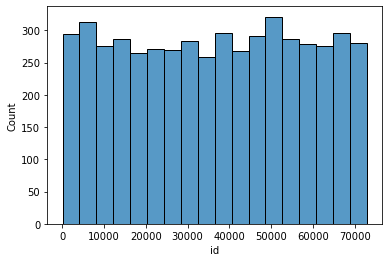

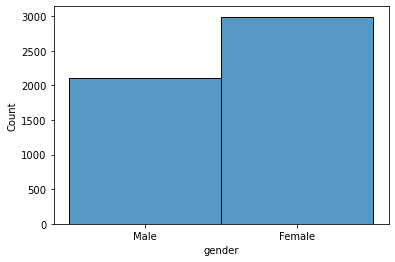

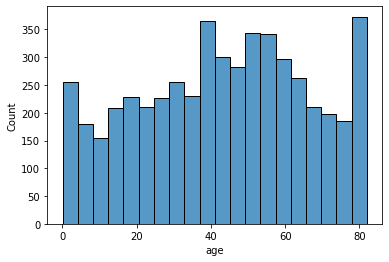

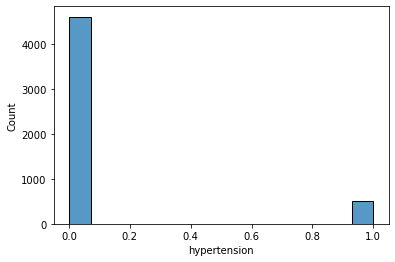

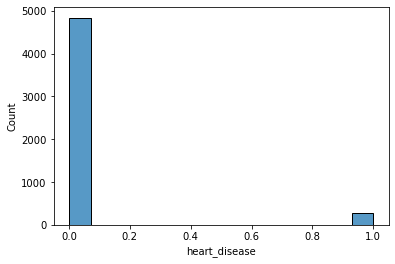

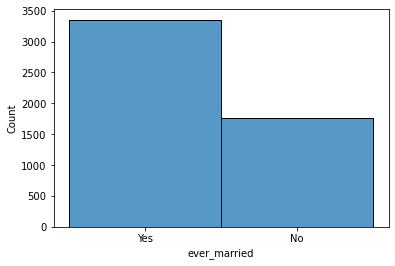

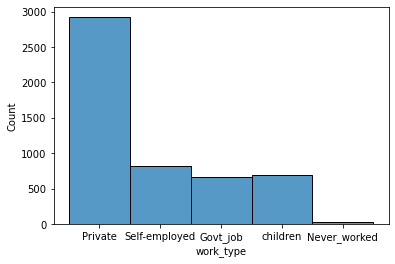

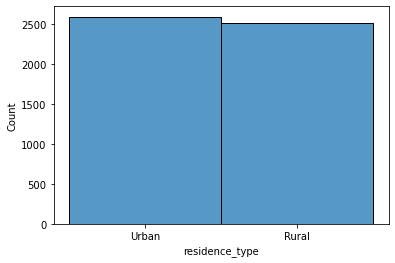

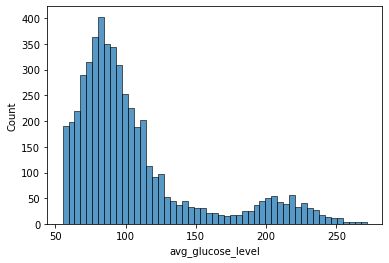

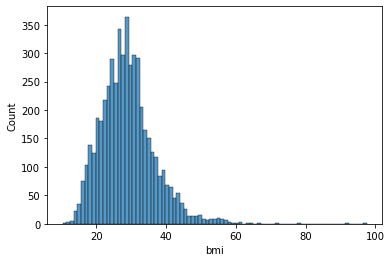

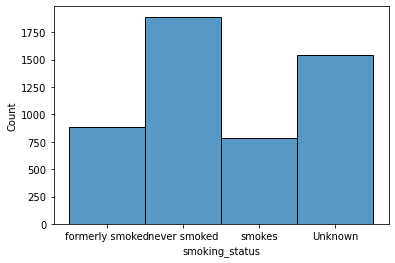

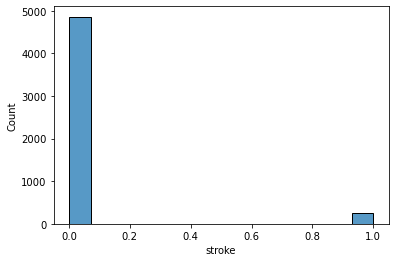

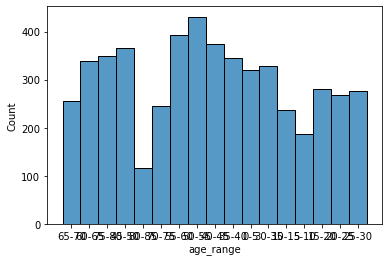

In [4]:
# creating the distribution plot for each column
for col in df.columns:
    sns.histplot(df[col])
    plt.show()

- age is left skewed
- average glucose level is right skewed
- bmi is close to normally distributed

# Splits

In [5]:
# split the dataset into train_validate and test
train_validate, test = train_test_split(df, test_size=.2, random_state=777)

In [6]:
# the second split of train and validate
train, validate = train_test_split(train_validate, test_size=.25, random_state=777)

In [7]:
# checking the shape of each dataset
train.shape, validate.shape, test.shape

((3065, 13), (1022, 13), (1022, 13))

# Hypothesis Testing

## Hypothesis 1:
> - $H_0$ : There is no relationship between average glucose level and bmi.
> - $H_A$ : There is relationship between average glucose level and bmi.
> - Confidence interval is 95%

In [8]:
alpha = .05

<AxesSubplot:xlabel='avg_glucose_level', ylabel='bmi'>

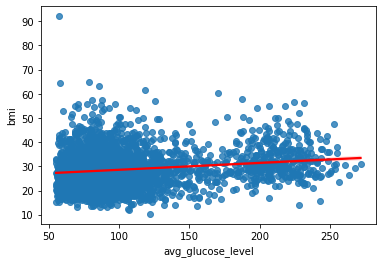

In [9]:
# creating a scatterplot to show the relationsip between avg glucose level and bmi
# hue= and bins= for colorization fanciness
sns.regplot(data=train, x="avg_glucose_level", y="bmi",line_kws={'color': 'red'})

In [11]:
# here we conduct a pearson r test 
corr, p = stats.pearsonr(train.avg_glucose_level, train.bmi)
corr, p

(0.1715254388784596, 1.1422802552175544e-21)

In [12]:
# comparing the p-value to alpha
if p < alpha:
    print('There is a relationship between average glucose level and bmi.')
else:
    print('We can not say with 95% confidence that there is a realionship between average glucose level and bmi.')

There is a relationship between average glucose level and bmi.


## Hypothesis 2:
> - $H_0$ : People over 65 years old are not more likely to have a stroke than people under 65.
> - $H_A$ : People over 65 years old are more likely to have a stroke than people under 65.

In [13]:
alpha = .05

In [14]:
over_65 = train[train.age >= 65]
under_65 = train[train.age < 65]

In [15]:
t, p = stats.mannwhitneyu(over_65.stroke, under_65.stroke, alternative='greater') #nonparametric t-test where the alternative
#comparing two sample means
#alternative: first subset is significantly greater than the second subset
t, p

(849465.0, 2.6226245960247797e-39)

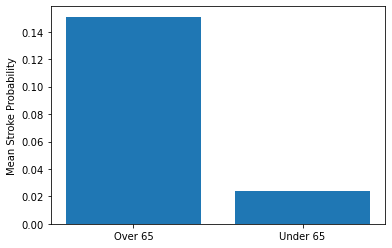

In [16]:
heights = [round(over_65.stroke.mean(), 3), round(under_65.stroke.mean(), 3)]
x_labels = ['Over 65', 'Under 65']
plt.bar(x=x_labels, height=heights)
plt.ylabel("Mean Stroke Probability")
plt.show()

In [17]:
# Comparing the p-value to alpha
if p < alpha and t > 0:
    print('People over 65 years old are more likely to have a stroke than people under 65')
else:
    print('We can not say with 95% confidence that people over 65 years old are not more likely to have a stroke than people under 65')

People over 65 years old are more likely to have a stroke than people under 65


## Hypothesis 3:
> - $H_0$ : People that currently smoke do not have a higher risk of stroke than people that don’t currently smoke.
> - $H_A$ : People that currently smoke have a higher risk of stroke than people that don’t currently smoke.

In [18]:
alpha = .05

In [19]:
train.smoking_status.value_counts()

never smoked       1124
Unknown             940
formerly smoked     517
smokes              484
Name: smoking_status, dtype: int64

In [20]:
active_smoker = train[train.smoking_status == "smokes"]
not_active_smoker = train[train.smoking_status != "smokes"]

t, p = stats.mannwhitneyu(active_smoker.stroke, not_active_smoker.stroke, alternative='greater') #nonparametric t-test where the alternative
#comparing two sample means
#alternative: first subset is significantly greater than the second subset
t, p

(637100.0, 0.031009877989108668)

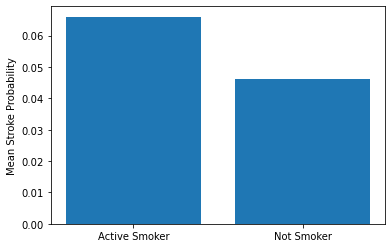

In [21]:
heights = [round(active_smoker.stroke.mean(), 3), round(not_active_smoker.stroke.mean(), 3)]
x_labels = ['Active Smoker', 'Not Smoker']
plt.bar(x=x_labels, height=heights)
plt.ylabel("Mean Stroke Probability")
plt.show()

In [22]:
# comparing the p-value to alpha
if p < alpha and t>0:
    print('People that currently smoke have a higher risk of stroke than people that don’t currently smoke.')
else:
    print('We can not say with 95% confidence that People that currently smoke have a higher risk of stroke than people that don’t currently smoke.')

People that currently smoke have a higher risk of stroke than people that don’t currently smoke.



## Hypothesis 4:
> - $H_0$ : Men are not more at risk for stroke than women.
> - $H_A$ : Men are more at risk for stroke than women.

In [23]:
alpha = .05

In [24]:
train.gender.value_counts()

Female    1806
Male      1259
Name: gender, dtype: int64

In [25]:
men = train[train.gender == "Male"]
women = train[train.gender != "Male"]

t, p = stats.mannwhitneyu(men.stroke, women.stroke, alternative='greater') #nonparametric t-test where the alternative
#comparing two sample means
#alternative: first subset is significantly greater than the second subset
t, p

(1141435.0, 0.30698159499864974)

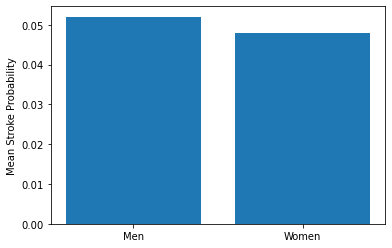

In [26]:
heights = [round(men.stroke.mean(), 3), round(women.stroke.mean(), 3)]
x_labels = ['Men', 'Women']
plt.bar(x=x_labels, height=heights)
plt.ylabel("Mean Stroke Probability")
plt.show()

In [27]:
# comparing the p-value to alpha
if p < alpha and t > 0:
    print('Men are more at risk for stroke than women.')
else:
    print('We can not say with 95% confidence that Men are more at risk for stroke than women.')

We can not say with 95% confidence that Men are more at risk for stroke than women.


# **Takeways**:
> - There is a relationship between average glucose level and bmi.
> - People over 65 years old are more likely to have a stroke than people under 65
> - People that currently smoke have a higher risk of stroke than people that don’t currently smoke.
> - We can not say with 95% confidence that Men are more at risk for stroke than women.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import prepare
import model
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [2]:
# prepare data using script
df = prepare.prep_data(df).drop(columns=['age_range', 'id'])
df.stroke.dtype

dtype('O')

In [3]:
# cast stroke column as int
df['stroke'] = df['stroke'].astype('int64')
# check work
df.shape

(5109, 11)

In [4]:
# check work
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.640331,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1


In [5]:
# set list of columns to one-hot encode
col_list = ['gender','ever_married','work_type','residence_type','smoking_status']
# apply one-hot encoding using above list
df = pd.get_dummies(df, columns=col_list, drop_first=True)

In [6]:
# split using same random state as explore stage
trainvalidate, test = train_test_split(df, test_size=.2, random_state=777)
train, validate = train_test_split(trainvalidate, test_size=.25, random_state=777)
# check work
train.shape, validate.shape, test.shape

((3065, 16), (1022, 16), (1022, 16))

In [7]:
# isolate target
X_train, y_train = train.drop(columns='stroke'), train.stroke
X_validate, y_validate = validate.drop(columns='stroke'), validate.stroke
X_test, y_test = test.drop(columns='stroke'), test.stroke

In [8]:
# apply scaling using a MinMaxScaler
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = model.Min_Max_Scaler(X_train, X_validate, X_test)

In [9]:
# build & fit models, append model predictions to the train and validate actuals dataframes
y_train_predictions,\
y_validate_predictions = model.classification_shotgun(X_train_scaled, y_train, X_validate_scaled, y_validate)

In [ ]:
y_train_predictions,\
y_validate_predictions = model.manual_baseline(y_train_predictions, y_validate_predictions, 1)

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
y_train_predictions

In [ ]:
# calculate accuracy and recall for in- and out-sample predictions
running_df = model.print_classification_results(y_train_predictions, y_validate_predictions)

In [ ]:
# display accuracies and recalls for each model, sorting for best out-sample recall
running_df.sort_values(by='OutSample_Recall', ascending=False)

# Post MVP Jake Starts

In [2]:
# clean original dataset up to explore stage
df = prepare.prep_data(pd.read_csv('healthcare-dataset-stroke-data.csv'))
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_range
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,65-70
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.6,never smoked,1,60-65
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,75-80


In [3]:
# encode, split, scale, SMOTE the explore-stage data
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.model_prep(df)
# check results
print('X_train with SMOTE:', X_train.shape)
print('y_train with SMOTE:', y_train.shape)
print('X_validate:', X_validate.shape)
print('y_validate:', y_validate.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

Before SMOTE applied: (3065, 31) (3065,)
After SMOTE applied: (5812, 31) (5812,)
X_train with SMOTE: (5812, 31)
y_train with SMOTE: (5812,)
X_validate: (1022, 31)
y_validate: (1022,)
X_test: (1022, 31)
y_test: (1022,)


### Model Prep Process
> - Takes the dataframe already put through prep_data as input,
> - One-hot encodes categorical and ordinal columns,
> - Splits data into 60-20-20 train-validate-test splits,
> - Isolates the target column from each split,
> - Scales each split's features,
> - Uses SMOTE to address class imbalance for train, and
> - Return all prepared dataframes. Requires prior prep function.

In [ ]:
X_train # features like gender_Male and work_type_Private have non-ordinal values because of SMOTE oversampling

In [5]:
# shotgun-out several classification models
y_train_predictions,\
y_validate_predictions = model.classification_shotgun(X_train, y_train, X_validate, y_validate)

In [6]:
# choose the baseline guess manually
y_train_predictions,\
y_validate_predictions = model.manual_baseline(y_train_predictions, y_validate_predictions, 1)

In [7]:
y_train_predictions # each model's predictions and the actuals column (in_actuals)

,in_actuals,baseline,tree_maxdepth1,tree_maxdepth2,tree_maxdepth3,tree_maxdepth5,tree_maxdepth10,rf_depth1,rf_depth2,rf_depth3,...,nb_vsmooth0.001,nb_vsmooth0.01,nb_vsmooth10,nb_vsmooth100,knn_n3,knn_n5,knn_n10,knn_n25,knn_n75,manual_baseline
0,0,0,1,1,1,1,0,1,1,1,...,1,1,1,1,0,0,0,0,1,1
1,0,0,1,1,1,1,0,1,1,1,...,1,1,1,1,0,0,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,0,0,1
4,0,0,1,1,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5807,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5808,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5809,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5810,1,0,1,1,1,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [8]:
# calculate accuracy and recall for in- and out-sample predictions
running_df = model.print_classification_results(y_train_predictions, y_validate_predictions)

In [9]:
# display accuracies and recalls for each model, sorting for best out-sample recall
running_df.sort_values(by=['OutSample_Recall','OutSample_Accuracy'], ascending=False)

,Model,InSample_Accuracy,OutSample_Accuracy,InSample_Recall,OutSample_Recall
14,nb_vsmooth1e-07,0.701136,0.449119,0.990021,1.000000
13,nb_vsmooth1e-08,0.691672,0.434442,0.990365,1.000000
12,nb_vsmooth1e-09,0.691156,0.432485,0.990709,1.000000
27,manual_baseline,0.500000,0.043053,1.000000,1.000000
3,tree_maxdepth3,0.813145,0.783757,0.879215,0.977273
1,tree_maxdepth1,0.787853,0.746575,0.868548,0.977273
2,tree_maxdepth2,0.787853,0.746575,0.868548,0.977273
19,nb_vsmooth0.01,0.747763,0.590020,0.945974,0.977273
18,nb_vsmooth0.001,0.748624,0.585127,0.955609,0.977273
17,nb_vsmooth0.0001,0.752409,0.582192,0.966621,0.977273


## ROC Curve
- A common way to compare models that predict probabilities for two-class problems is to use a ROC curve.
- ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.
- It can be more flexible to predict the probabilities for each class instead of predicting the outcome itself. 
    * The reason for this is to provide the capability to choose and even **calibrate the threshold** for how to interpret the predicted probabilities.
     * For example, a default might be to use a threshold of 0.5, meaning that a probability in [0.0, 0.49] is a negative outcome (0) and a probability in [0.5, 1.0] is a positive outcome (1).

In [10]:
bl_probs = [0 for _ in range(len(y_train))]
tree = DecisionTreeClassifier(max_depth=3, random_state=123).fit(X_train, y_train)

In [11]:
# THRESHOLD = .60
# preds = np.where(tree.predict_proba(X_train) > THRESHOLD, 1, 0)
# tree_probs = preds[:, 1]
tree_probs = tree.predict_proba(X_train)
tree_probs = tree_probs[:, 1]

In [12]:
bl_auc = roc_auc_score(y_train, bl_probs)
tree_auc = roc_auc_score(y_train, tree_probs)

In [13]:
print('Baseline: ROC AUC=%.3f' % (bl_auc))
print('DecisionTreeClassifier: ROC AUC=%.3f' % (tree_auc))

Baseline: ROC AUC=0.500
DecisionTreeClassifier: ROC AUC=0.872


In [14]:
bl_fpr, bl_tpr, _ = roc_curve(y_train, bl_probs)
tree_fpr, tree_tpr, _ = roc_curve(y_train, tree_probs)
print("x axis:")
print(tree_fpr.round(5).tolist())
print("y axis:")
print(tree_tpr.round(5).tolist())

x axis:
[0.0, 0.0, 0.01824, 0.12251, 0.25292, 0.46869, 0.5086, 1.0]
y axis:
[0.0, 0.02099, 0.24054, 0.62801, 0.87922, 0.97213, 0.98245, 1.0]


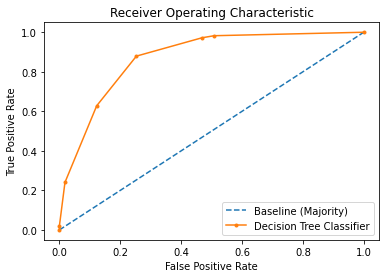

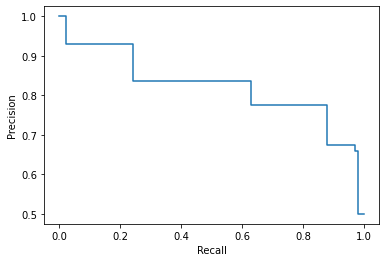

In [15]:
plt.plot(bl_fpr, bl_tpr, linestyle='--', label='Baseline (Majority)')
plt.plot(tree_fpr, tree_tpr, marker='.', label='Decision Tree Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()
# plot the precision-recall curve for the model
precision, recall, _ = precision_recall_curve(y_train, tree_probs)
disp = PrecisionRecallDisplay(precision = precision, recall = recall)
disp.plot()